In [1]:
import tensorflow as tf

from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K
from tensorflow.keras import mixed_precision
from tensorflow.keras.models import load_model

import numpy as np
import gc

rs = 1128

mixed_precision.set_global_policy('mixed_float16')

tf.random.set_seed(rs)
np.random.seed(rs)

2024-06-22 11:58:48.439543: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-22 11:58:48.439625: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-22 11:58:48.542824: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import os
import random

import pandas as pd


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, classification_report, confusion_matrix, det_curve,ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

import keras
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import HeNormal


import cv2 as cv

import matplotlib.pyplot as plt
import seaborn as sns


# Paths to your data
base_dir = '/kaggle/input/leukemia-classification'  # Replace with your directory (whatever current directory this notebook is in)
train_dir = os.path.join(base_dir, 'C-NMC_Leukemia/training_data/') # make sure this data is in the base_dir
test_csv = os.path.join(base_dir, 'C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data_labels.csv')
test_imgs = os.path.join(base_dir, 'C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/')




# Function to define file paths and labels
def define_paths(dir):
    filepaths = []
    labels = []

    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)

        for fold_ in filelist:
            foldpath_ = os.path.join(foldpath, fold_)
            filelist_ = os.listdir(foldpath_)

            for file_ in filelist_:
                fpath = os.path.join(foldpath_, file_)
                filepaths.append(fpath)
                labels.append(fold_)

    return filepaths, labels


def get_test_df(base_dir):
    test_data = pd.read_csv(test_csv)

    X_test = []

    for image_name in test_data.new_names:
        # Loading images
        img = test_imgs + image_name
  
        X_test.append(img)
    
    # Storing target values as well 
    y_test = test_data.labels.values
    test_df = pd.DataFrame({'filepaths':X_test,'labels':y_test})
    test_df['labels'] = test_df['labels'].apply(lambda x: 'all' if x==1 else 'hem')
    return test_df
    
    


# Concatenate data paths with labels into one dataframe ( to later be fitted into the model )
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)


# Function that create dataframe for train, validation, and test data
def create_df(data_dir):

    # train dataframe
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)
    
    train_df, valid_df = train_test_split(df, train_size=0.8, random_state=rs)

    return train_df, valid_df


batch_size = 64

# Create dataframes for train, validation, and test data
train_df, val_df = create_df(train_dir)
test_df = get_test_df(base_dir)


# Print updated DataFrames to debug
print("\nUpdated first few rows of train_df:")
print(train_df.head())

print("\nUpdated first few rows of val_df:")
print(val_df.head())

print("\nUpdated first few rows of test_df:")
print(test_df.head())

def crop_image(image):
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    if gray.dtype != np.uint8:
        gray = cv.convertScaleAbs(gray, alpha=(255.0 / gray.max()))

    thresh = cv.threshold(gray, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)[1]

    result = cv.bitwise_and(image, image, mask=thresh)
    result[thresh==0] = [255,255,255] 
    (x, y, z_) = np.where(result > 0)
    mnx,mxx = (np.min(x)),(np.max(x))
    mny,mxy = (np.min(y)),(np.max(y))

    crop_img = image[mnx:mxx,mny:mxy,:]
    crop_img_r = cv.resize(crop_img, (224,224))
    return crop_img_r
    
# Image Data Generators for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function = crop_image
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function = crop_image
)    

augment_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = val_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

print("Setup complete.")


Updated first few rows of train_df:
                                              filepaths labels
576   /kaggle/input/leukemia-classification/C-NMC_Le...    all
5211  /kaggle/input/leukemia-classification/C-NMC_Le...    all
6761  /kaggle/input/leukemia-classification/C-NMC_Le...    hem
3969  /kaggle/input/leukemia-classification/C-NMC_Le...    all
8238  /kaggle/input/leukemia-classification/C-NMC_Le...    all

Updated first few rows of val_df:
                                              filepaths labels
8987  /kaggle/input/leukemia-classification/C-NMC_Le...    all
1460  /kaggle/input/leukemia-classification/C-NMC_Le...    all
6290  /kaggle/input/leukemia-classification/C-NMC_Le...    hem
5208  /kaggle/input/leukemia-classification/C-NMC_Le...    all
114   /kaggle/input/leukemia-classification/C-NMC_Le...    all

Updated first few rows of test_df:
                                           filepaths labels
0  /kaggle/input/leukemia-classification/C-NMC_Le...    all
1  /kaggle/input

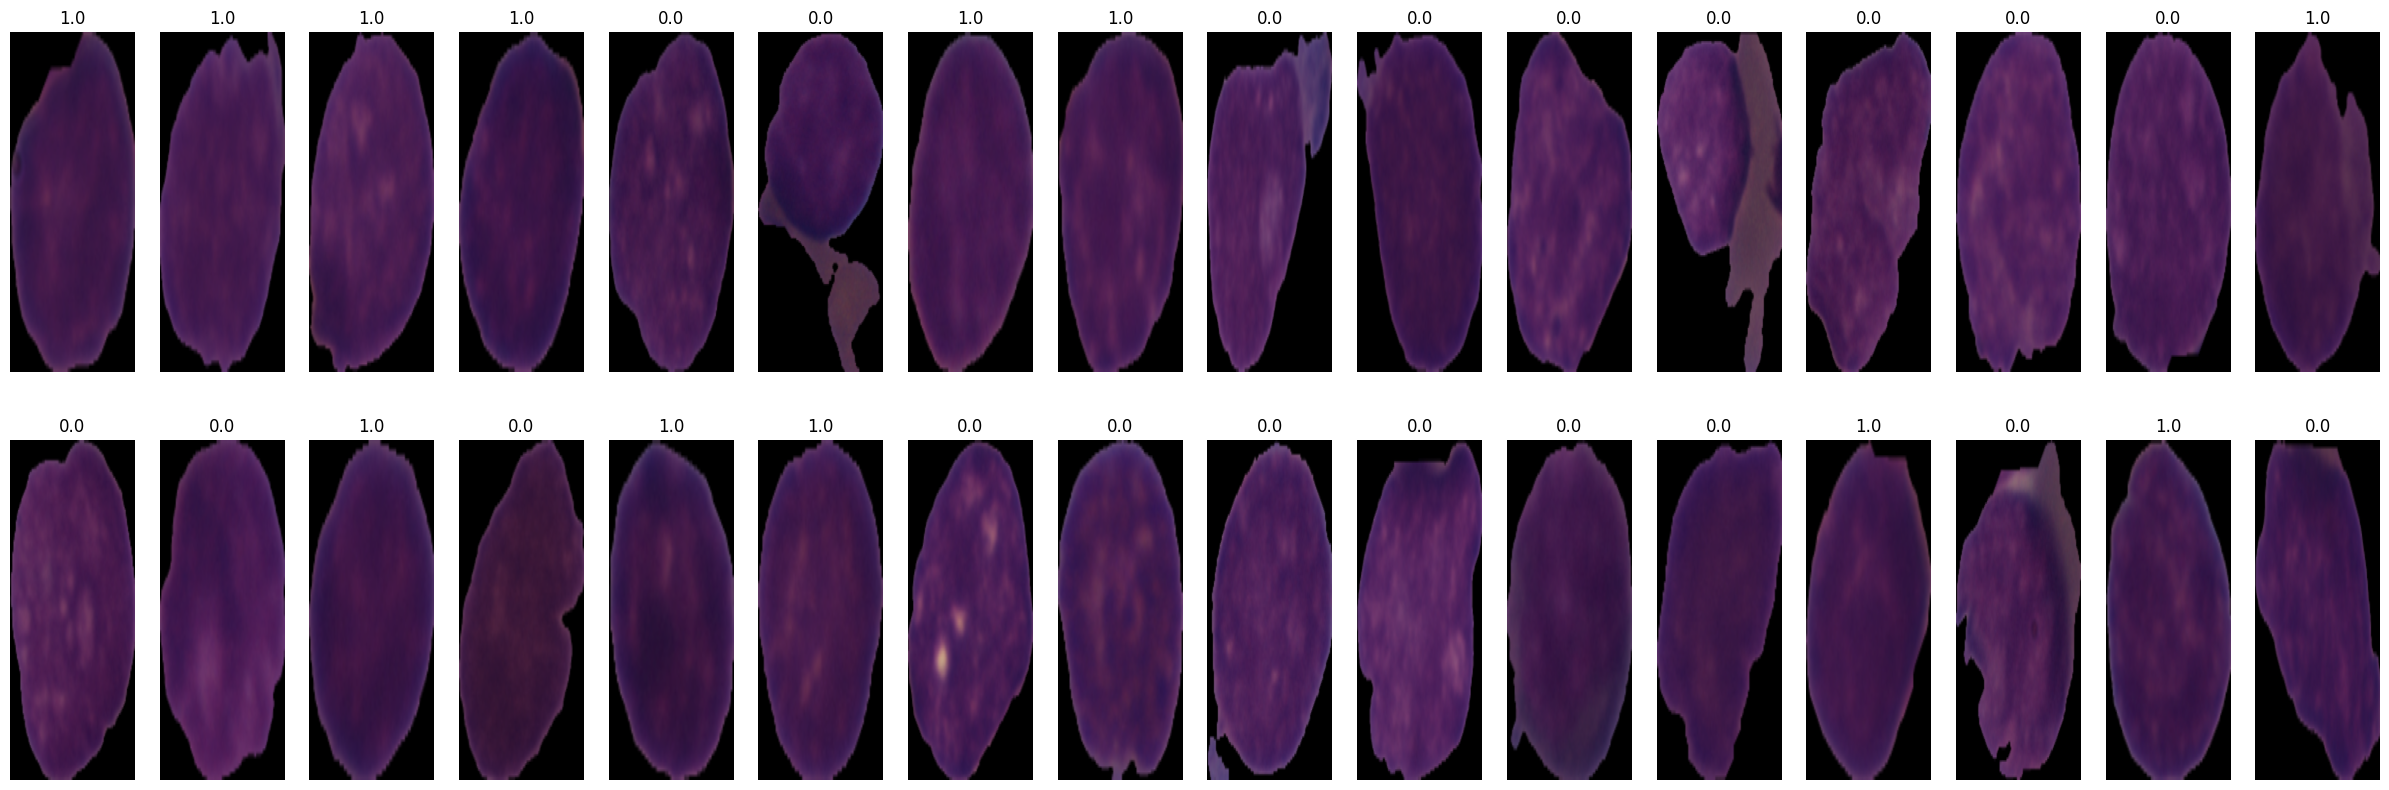

In [3]:
from keras.regularizers import l2

def visualise_images(data_generator):
    images,labels = next(data_generator)
    batch_size = images.shape[0]
    
    fig, axes = plt.subplots(2, batch_size//4, figsize=(24, 8))
    axes = axes.flatten()
    
    for img,lbl, ax in zip(images[:batch_size//2],labels[:batch_size//2], axes):
        ax.imshow(img)
        ax.set_title(lbl)
        ax.axis('tight')
        ax.axis('off')
        
        
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()
    


visualise_images(train_generator)

In [4]:

def get_predictions(data_generator,model,max_batches):
    y_true,y_pred = [],[]
    batch_count = 0
    for X_batch, y_batch in data_generator:
        pred_batch = model.predict(X_batch)
        if not isinstance(y_batch,np.ndarray):
            y_true.extend(y_batch.numpy())
        else:
            y_true.extend(y_batch)
        y_pred.extend(pred_batch)
        
        batch_count+= 1
        
        if batch_count >= max_batches:
            break
        
    return np.array(y_true),np.array(y_pred)

def data_from_gen(data_generator,max_batches):
    X,y = [],[]
    
    batch_count = 0
    
    for X_batch, y_batch in data_generator:
        y.extend(y_batch)
        X.extend(X_batch)
        
        batch_count+= 1
        
        if batch_count >= max_batches:
            break

    return np.array(X),np.array(y)
  
def eval(generator_test, generator_train, generator_val, model,steps_per_epoch):
    
    y_val_true,y_val_pred = get_predictions(generator_val,model,len(generator_val))
    
    y_val_pred_flat = y_val_pred.reshape(-1) 
    y_val_pred_flat_thresh = y_val_pred >0.5
    y_val_true_flat = y_val_true.reshape(-1)
    
    
   
    cm_val = confusion_matrix(y_val_true_flat, y_val_pred_flat_thresh)
    f1_val = f1_score(y_val_true_flat, y_val_pred_flat_thresh)

    # Evaluate on test set
    y_test_true, y_test_pred = get_predictions(generator_test,model,len(generator_test))
    
    y_test_pred_flat = y_test_pred.reshape(-1)
    y_test_pred_flat_thresh = y_test_pred_flat > 0.5
    y_test_true_flat = y_test_true.reshape(-1)
    
    
    cm_test = confusion_matrix(y_test_true, y_test_pred_flat_thresh)
    f1_test = f1_score(y_test_true, y_test_pred_flat_thresh)
 

 
    y_train_true,y_train_pred = get_predictions(generator_train,model,steps_per_epoch)
    
    y_train_pred_flat = y_train_pred.reshape(-1) 
    y_train_pred_flat_thresh = y_train_pred > 0.5
    y_train_true_flat = y_train_true.reshape(-1)
    
    cm_train = confusion_matrix(y_train_true_flat, y_train_pred_flat_thresh)
    f1_train = f1_score(y_train_true_flat, y_train_pred_flat_thresh)
  

    print(f"ROC-AUC score test: {roc_auc_score(y_test_true_flat, y_test_pred_flat, average='weighted')}\n")
    print(f"ROC-AUC score validation: {roc_auc_score(y_val_true_flat, y_val_pred_flat, average='weighted')}\n")
    
    print(f"Test: \n {classification_report(y_test_true_flat, y_test_pred_flat_thresh)}")
    print(f"Val:\n {classification_report(y_val_true_flat, y_val_pred_flat_thresh)}")
    print(f"Train:\n {classification_report(y_train_true_flat, y_train_pred_flat_thresh)}")
    
    fpr_test, tpr_test, _ = roc_curve(y_test_true_flat, y_test_pred_flat)
    roc_auc_test = auc(fpr_test, tpr_test)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_test)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve Test')
    plt.legend(loc='lower right')
    
    fpr_val, tpr_val, _ = roc_curve(y_val_true_flat, y_val_pred_flat)
    roc_auc_val = auc(fpr_val, tpr_val)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_val, tpr_val, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_val)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve Validation')
    plt.legend(loc='lower right')
    
    fig, axes = plt.subplots(2, 1, figsize=(15, 14))
    test_fpr_det, test_fnr_det, _ = det_curve(y_test_true_flat, y_test_pred_flat)
    axes[1].plot(test_fpr_det, test_fnr_det)
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('False Negative Rate')
    axes[1].set_title('DET Curve (Test)')
    
    val_fpr_det, val_fnr_det, _ = det_curve(y_val_true_flat, y_val_pred_flat)
    axes[0].plot(val_fpr_det, val_fnr_det)
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('False Negative Rate')
    axes[0].set_title('DET Curve (Validation)')

    fig, axs = plt.subplots(3, 1, figsize=[10, 20])
    
    c = ConfusionMatrixDisplay(cm_test)
    c.plot(ax = axs[0])

    c = ConfusionMatrixDisplay(cm_train)
    c.plot(ax = axs[1])
    
    c = ConfusionMatrixDisplay(cm_val)
    c.plot(ax = axs[2])

    axs[0].set_title(f'Confusion Matrix for Test Set - F1-Score: {f1_test}')
    axs[0].set_xlabel('Predicted label')
    axs[0].set_ylabel('True label')
    
    axs[1].set_title(f'Confusion Matrix for Train Set - F1-Score: {f1_train}')
    axs[1].set_xlabel('Predicted label')
    axs[1].set_ylabel('True label')
    
    axs[2].set_title(f'Confusion Matrix for Validation Set - F1-Score: {f1_val}')
    axs[2].set_xlabel('Predicted label')
    axs[2].set_ylabel('True label')

Steps per epoch:181


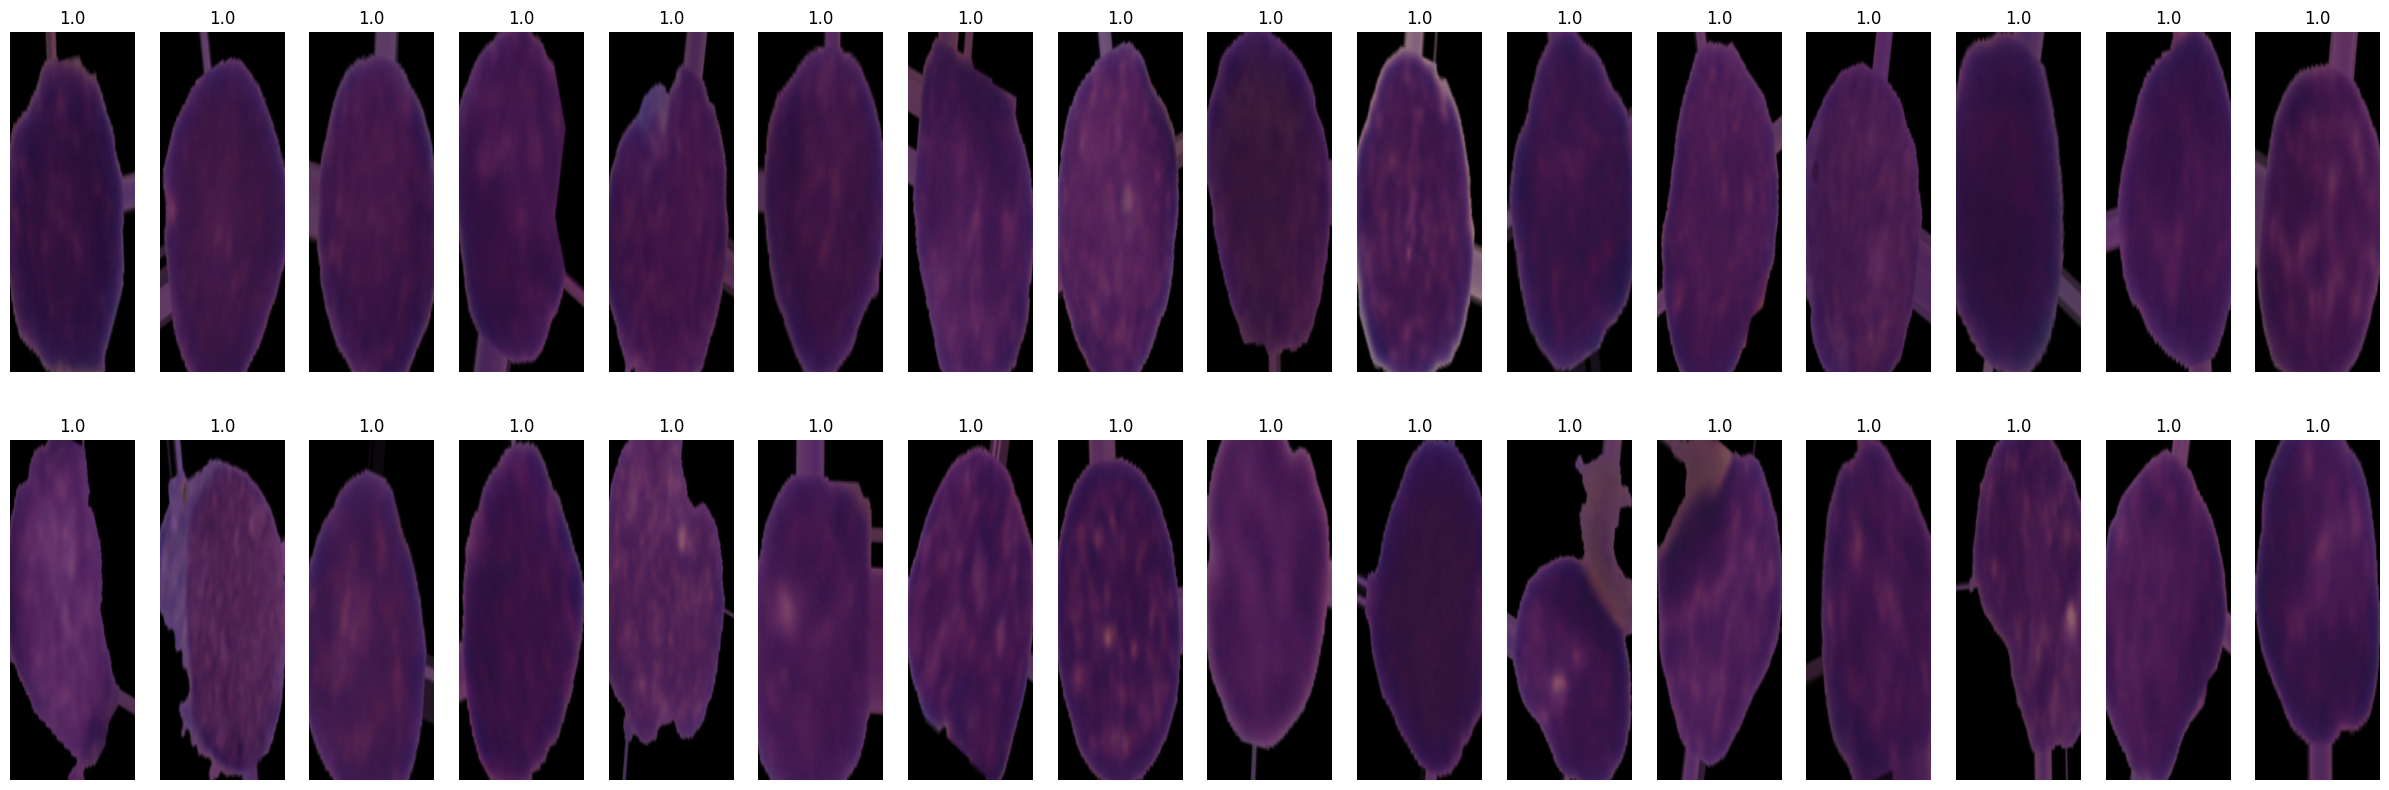

In [5]:
#oversample minority class
def get_oversample_augment(data_generator,batch_size):
    train_X,train_y = data_from_gen(data_generator,len(data_generator))
    class_counts = np.unique(train_y,return_counts=True)
    oversample_class = class_counts[0][np.argmin(class_counts[1])]
    num_oversample = max(class_counts[1])-min(class_counts[1])

    samples = train_X[train_y==oversample_class]

    total_train  =  2*max(class_counts[1])
    steps_per_epoch =  np.ceil(total_train//batch_size).astype(int) 
    
    repeats = np.ceil(num_oversample  / len(samples)).astype(int)
    oversample = np.tile(samples,(repeats,1,1,1))
    oversample = oversample[:num_oversample]



    return augment_datagen.flow(oversample,np.ones(oversample.shape[0],),batch_size=batch_size),steps_per_epoch

augment_oversample,steps_per_epoch = get_oversample_augment(train_generator,batch_size)

print(f"Steps per epoch:{steps_per_epoch}")
visualise_images(augment_oversample)

In [6]:
#create df dataset of combined oversample and original train data

img_size = (224,224,3)
def get_oversample_tfds(original_ds,oversample_ds,img_size):
    
    ot = (tf.float32, tf.float16)
    os = ([None, *img_size], [None,])
    default_train_ds = tf.data.Dataset.from_generator(lambda: original_ds,
                                                    output_types=ot,
                                                    output_shapes=os
                                               )
    augment_train_ds = tf.data.Dataset.from_generator(lambda: oversample_ds,
                                                        output_types=ot,
                                                        output_shapes=os
                                                        )

    train_oversample = default_train_ds.concatenate(augment_train_ds)

    return train_oversample.prefetch(tf.data.AUTOTUNE)

train_oversample = get_oversample_tfds(train_generator,augment_oversample,img_size)

In [7]:
def plot_class_history(history,custom_title=""):
    fig = plt.figure(figsize=[20, 10])
    ax = fig.add_subplot(2, 1, 1)
    ax.plot(history.history['loss'], label='train loss')
    ax.plot(history.history['val_loss'], label='val loss')
    ax.set_title('Training Loss - '+ custom_title)
    ax.legend()
    
    fig = plt.figure(figsize=[20, 10])
    ax = fig.add_subplot(2, 1, 1) 
    ax.plot(history.history['accuracy'], label='train accuracy')
    ax.plot(history.history['val_accuracy'], label='val accuracy')
    ax.set_title('Accuracy - ' + custom_title)
    ax.legend()

In [18]:
from keras.applications import ResNet50V2

def create_model(dropout_extent,regularizer_strength):
    n_network = ResNet50V2(include_top=False,weights="imagenet",input_shape=img_size,pooling="avg")
    n_network.trainable = False
    
    inputs = layers.Input(img_size)
    x = n_network(inputs)
    x = Dense(256, activation='relu',kernel_regularizer=l2(regularizer_strength))(x)
    x = Dropout(dropout_extent)(x)
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu',kernel_regularizer=l2(regularizer_strength))(x)
    x = Dropout(dropout_extent)(x)
    x = BatchNormalization()(x)
    classification_head = layers.Dense(1, activation='sigmoid', name='classification_head')(x)
    return keras.Model(inputs,classification_head)


n_network = create_model(0.5,0)

n_network.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'], jit_compile=True)
n_network.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 2048)           │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification_head (Dense)     │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,123,905 (92.03 MB)

 Trainable params: 558,337 (2.13 MB)

 Non-trainable params: 23,565,568 (89.90 MB)

In [10]:
del train_df
del val_df
del test_df
gc.collect()

107911

In [19]:
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

def checkpoint(save_name):
    return ModelCheckpoint(save_name,save_best_only=True)

def reduce_lr(min_lr):
    return ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=4, min_lr=min_lr)

Epoch 1/20
  2/181 ━━━━━━━━━━━━━━━━━━━━ 13s 78ms/step - accuracy: 0.5938 - loss: 0.8467 

W0000 00:00:1719059165.026321     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.7056 - loss: 0.6263

W0000 00:00:1719059223.416249     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


181/181 ━━━━━━━━━━━━━━━━━━━━ 85s 386ms/step - accuracy: 0.7059 - loss: 0.6260 - val_accuracy: 0.8233 - val_loss: 0.4247 - learning_rate: 0.0010
Epoch 2/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 55s 306ms/step - accuracy: 0.8023 - loss: 0.4640 - val_accuracy: 0.8298 - val_loss: 0.4063 - learning_rate: 0.0010
Epoch 3/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 56s 313ms/step - accuracy: 0.8161 - loss: 0.4328 - val_accuracy: 0.8401 - val_loss: 0.3832 - learning_rate: 0.0010
Epoch 4/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 55s 305ms/step - accuracy: 0.8205 - loss: 0.4126 - val_accuracy: 0.8425 - val_loss: 0.3789 - learning_rate: 0.0010
Epoch 5/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 52s 288ms/step - accuracy: 0.8350 - loss: 0.3944 - val_accuracy: 0.8453 - val_loss: 0.3749 - learning_rate: 0.0010
Epoch 6/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 50s 276ms/step - accuracy: 0.8277 - loss: 0.4011 - val_accuracy: 0.8500 - val_loss: 0.3771 - learning_rate: 0.0010
Epoch 7/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 50s 279ms/step - accuracy: 0.8332 - loss:

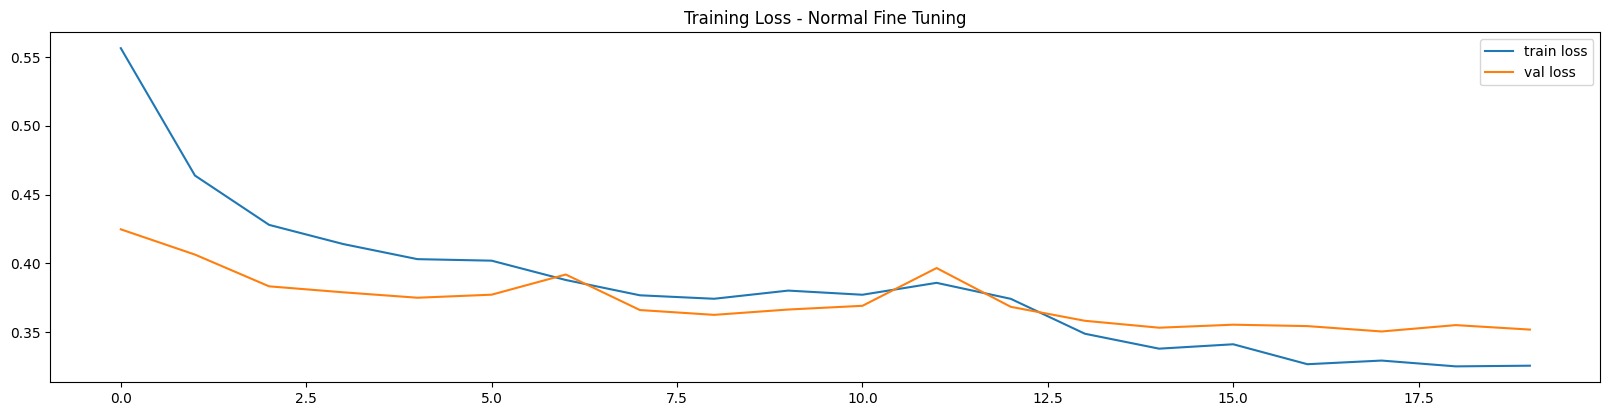

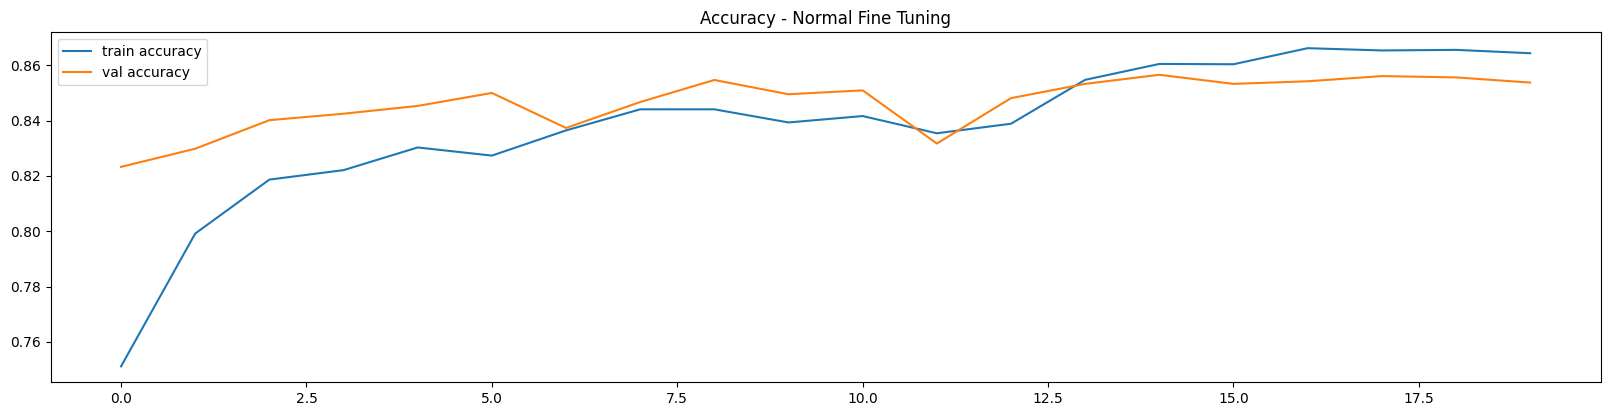

In [20]:
n_history = n_network.fit(train_oversample,steps_per_epoch=steps_per_epoch, validation_data=val_generator, epochs=20,callbacks=[early_stopping,checkpoint('init.keras'),reduce_lr(1e-5)])
plot_class_history(n_history,"Normal Fine Tuning")

In [21]:
del n_history

K.clear_session()
gc.collect()

mixed_precision.set_global_policy('mixed_float16')

tf.random.set_seed(rs)
np.random.seed(rs)

In [22]:
n_network = load_model('init.keras')

for layer in n_network.layers:
    layer.trainable = True

n_network.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'], jit_compile=True)
n_network.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 2048)           │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification_head (Dense)     │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,123,905 (92.03 MB)

 Trainable params: 24,077,697 (91.85 MB)

 Non-trainable params: 46,208 (180.50 KB)

Epoch 1/30
  1/181 ━━━━━━━━━━━━━━━━━━━━ 3:28:41 70s/step - accuracy: 0.5938 - loss: 1.0621

W0000 00:00:1719060297.743812     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.8137 - loss: 0.4342

W0000 00:00:1719060389.076346     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


181/181 ━━━━━━━━━━━━━━━━━━━━ 174s 578ms/step - accuracy: 0.8140 - loss: 0.4336 - val_accuracy: 0.7998 - val_loss: 0.4712 - learning_rate: 1.0000e-04
Epoch 2/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 58s 324ms/step - accuracy: 0.9342 - loss: 0.1832 - val_accuracy: 0.7712 - val_loss: 0.6283 - learning_rate: 1.0000e-04
Epoch 3/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 60s 330ms/step - accuracy: 0.9685 - loss: 0.1012 - val_accuracy: 0.8537 - val_loss: 0.4499 - learning_rate: 1.0000e-04
Epoch 4/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 60s 334ms/step - accuracy: 0.9745 - loss: 0.0792 - val_accuracy: 0.8992 - val_loss: 0.2760 - learning_rate: 1.0000e-04
Epoch 5/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 54s 297ms/step - accuracy: 0.9809 - loss: 0.0629 - val_accuracy: 0.8617 - val_loss: 0.5252 - learning_rate: 1.0000e-04
Epoch 6/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 56s 312ms/step - accuracy: 0.9855 - loss: 0.0526 - val_accuracy: 0.9306 - val_loss: 0.2121 - learning_rate: 1.0000e-04
Epoch 7/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 53s 295ms/step -

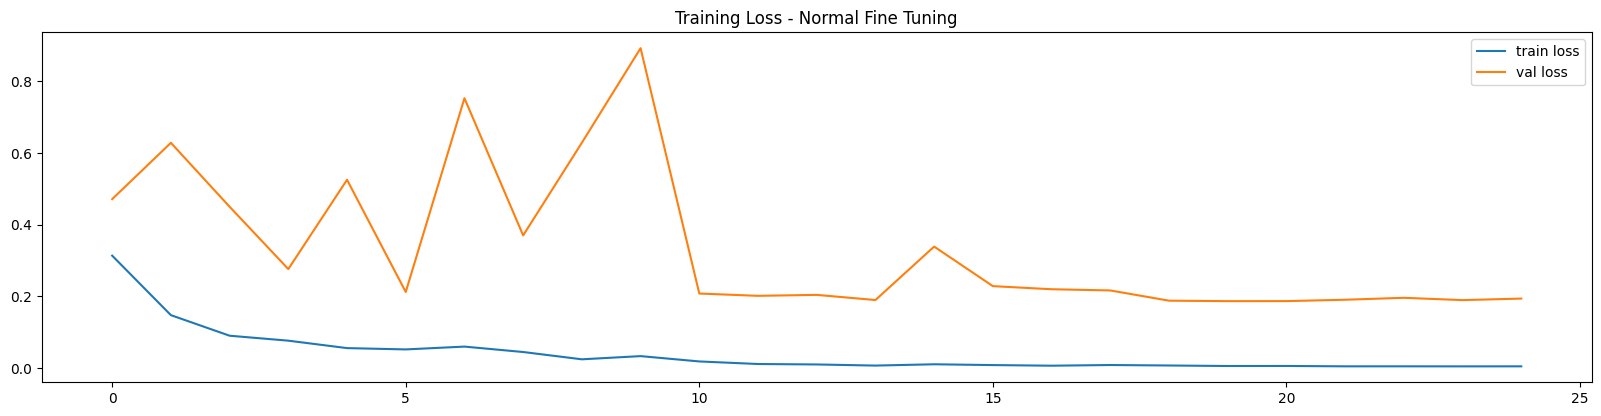

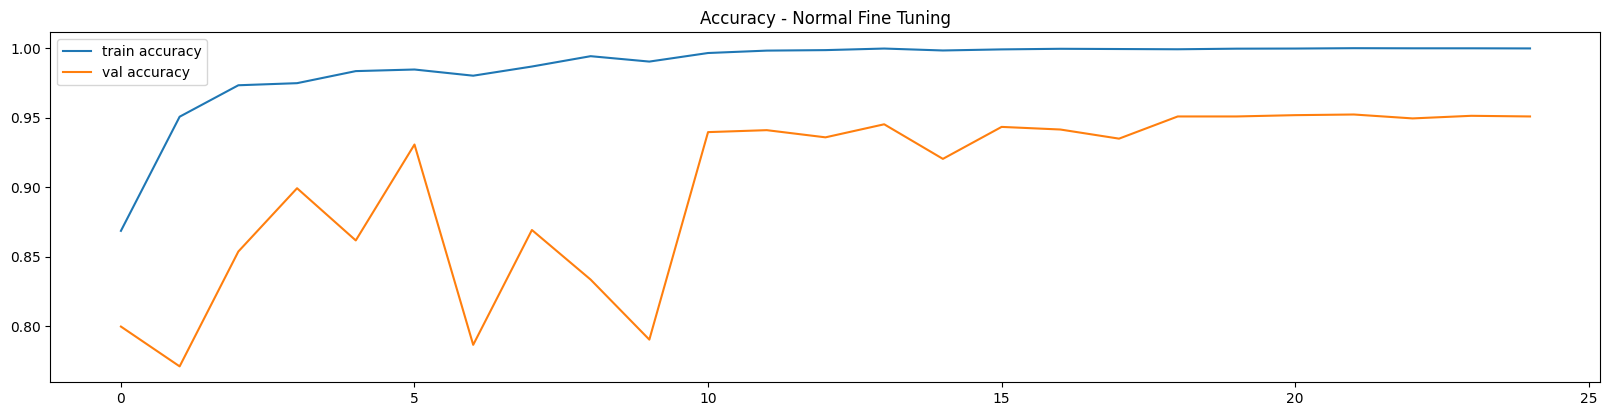

In [23]:
fn_history = n_network.fit(train_oversample,steps_per_epoch=steps_per_epoch, validation_data=val_generator, epochs=30,callbacks=[early_stopping,checkpoint('final.keras'),reduce_lr(1e-7)])
plot_class_history(fn_history,"Normal Fine Tuning")

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━

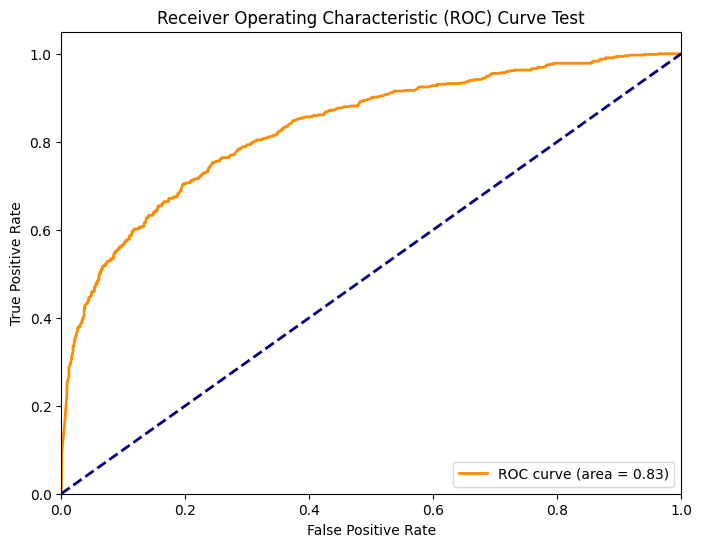

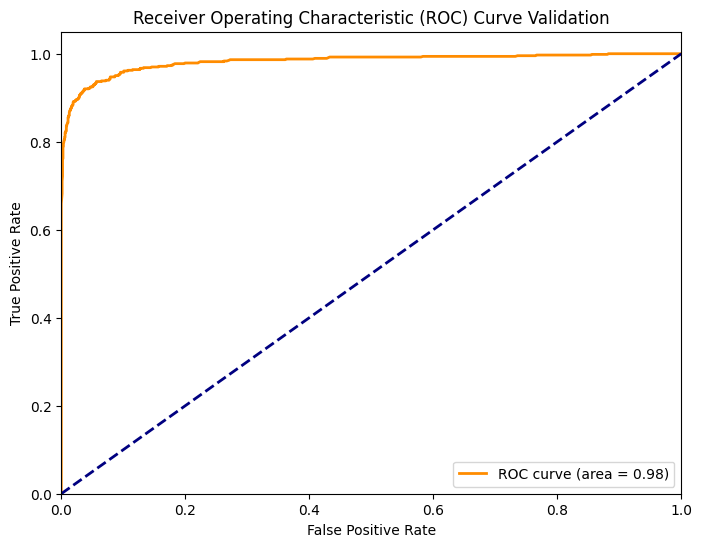

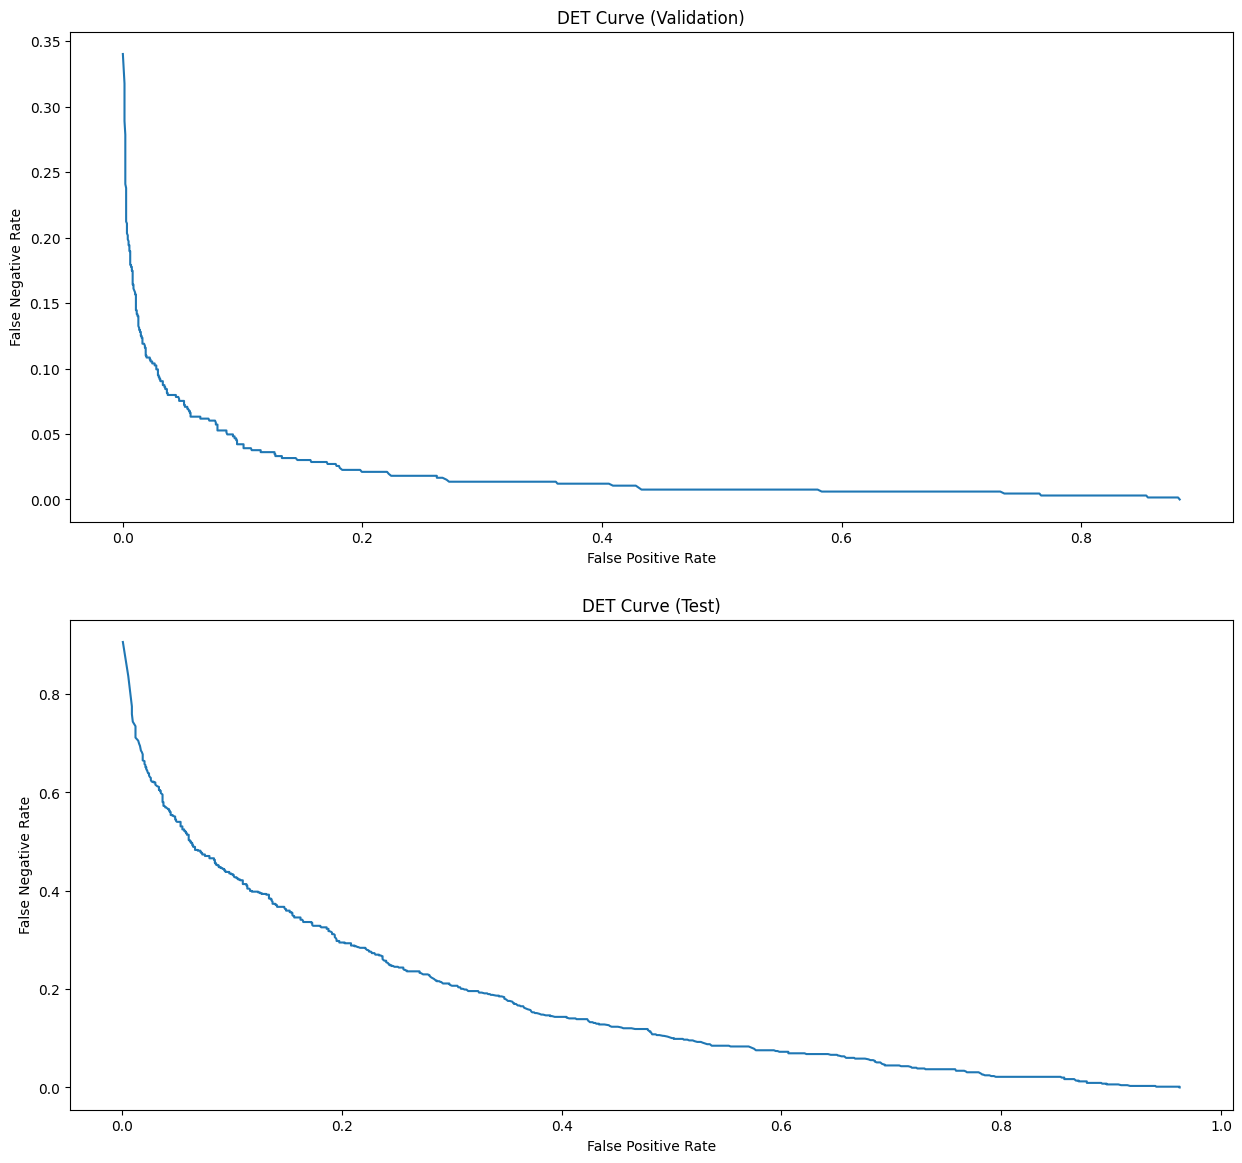

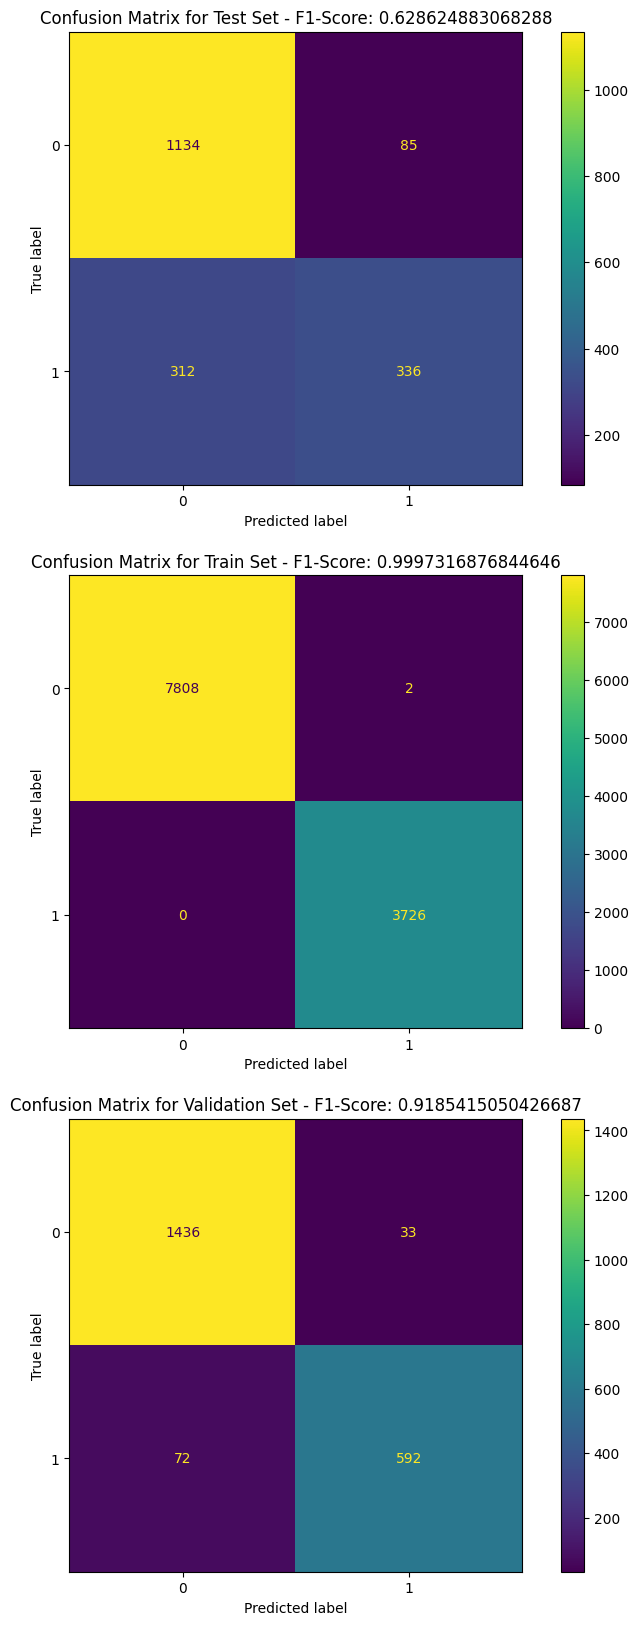

In [24]:
n_network = load_model('final.keras')
eval(test_generator, train_oversample, val_generator, n_network,steps_per_epoch)